## VrInstrumental Variables Example

In [4]:
# Copyright [2021] [Alessio Russo - alessior@kth.se]  
# This file is part of PythonVRFT.
# PythonVRFT is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, version 3 of the License.
# PythonVRFT is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
# You should have received a copy of the GNU General Public License
# along with PythonVRFT.  If not, see <http://www.gnu.org/licenses/>.
#
# Code author: [Alexander Berndt - alberndt@kth.se]
# Last update: 08th January 2021, by alberndt@kth.se
#

# Example 4
# ------------
# In this example we see how to apply VRFT to a 
# more complex SISO model, specifically, the three-pulley 
# system analyzed in the original VRFT paper:
# 
# "Virtual reference feedback tuning: 
#      a direct method for the design offeedback controllers"
# -- Campi et al. 2003
# 
# As in Example 3, we consider the case of  measurement 
# noise using instrumental variables. Input data is generated 
# using random normal noise
#

### Load libraries

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as scipysig
from vrft import *

### System, Reference Model and Control law

In [6]:
# System
dt = 0.05

# Plant P(z) 
num_P = [0.28261, 0.50666]
den_P = [1, -1.41833, 1.58939, -1.31608, 0.88642]
sys = ExtendedTF(num_P, den_P, dt=dt)

sigma = 0.5  # measurement noise

# Reference Model
#            z^-3 (1-alpha)^2
# M(z) =   ---------------------
#           (1 - alpha z^-1)^2 
# 
#       with alpha = e^{-dt omega}, omega = 10
#
omega = 10
alpha = np.exp(-dt*omega)
num_M = [(1-alpha)**2] 
den_M = [1, -2*alpha, alpha**2, 0]
refModel = ExtendedTF(num_M, den_M, dt=dt)

# Controller C(z,O) where O is $\theta$
#
#             O_0 z^5 + O_1 z^4 + O_2 z^3 + O_3 z^2 + O_4 z^1 + O_5 
# C(z,O) =   -------------------------------------------------------
#                                  z^5 - z^4
#
control = [ExtendedTF([1, 0], [1, -1], dt=dt),
           ExtendedTF([1], [1, -1], dt=dt),
           ExtendedTF([1], [1, -1, 0], dt=dt),
           ExtendedTF([1], [1, -1, 0, 0], dt=dt),
           ExtendedTF([1], [1, -1, 0, 0, 0], dt=dt),
           ExtendedTF([1], [1, -1, 0, 0, 0, 0], dt=dt)]



### Generate signals

In [7]:
# Function used to generate the data
def generate_data(sys, u, t, sigma):
    t, y = scipysig.dlsim(sys, u, t)
    y = y.flatten() + sigma * np.random.normal(size = t.size)

    # Length of the initial condition depends on the reference model
    return iddata(y, u, dt, [0])

# Generate input siganl
t_start = 0
t_end = 10
t = np.arange(t_start, t_end, dt)
u = np.random.normal(size = t.size)

# To use IV we must perform 2 experiments on the plant using the same input
data1 = generate_data(sys, u, t, sigma)
data2 = generate_data(sys, u, t, sigma)
data = [data1, data2]


### VRFT

In [8]:
# VRFT Pre-filter
prefilter = refModel * (1 -  refModel)

# VRFT method with Instrumental variables
theta_iv, r_iv, loss_iv, C_iv = compute_vrft(data, refModel, control, prefilter, iv=True)

# VRFT method without Instrumental variables
theta_noiv, r_noiv, loss_noiv, C_noiv = compute_vrft(data1, refModel, control, prefilter, iv=False)

#Obtained controller
print('------IV------')
print("Loss: {}\nTheta: {}\nController: {}".format(loss_iv, theta_iv, C_iv))
print('------No IV------')
print("Loss: {}\nTheta: {}\nController: {}".format(loss_noiv, theta_noiv, C_noiv))

------IV------
Loss: 0.07722599782177587
Theta: [ 0.26615509 -0.384969    0.38054354 -0.32386644  0.26931343 -0.05030538]
Controller: ExtendedTF(
array([ 0.26615509, -1.44958936,  3.51735008, -5.22047496,  5.65407152,
       -4.97790091,  3.49311141, -1.70295245,  0.47053496, -0.05030538,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ]),
array([  1.,  -5.,  10., -10.,   5.,  -1.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.]),
dt: 0.05
)
------No IV------
Loss: 0.034924767282308485
Theta: [ 0.15616351 -0.12160494  0.0341869  -0.0013284   0.04787493  0.0209244 ]
Controller: ExtendedTF(
array([ 0.15616351, -0.746259  ,  1.45758777, -1.49235973,  0.90089324,
       -0.4368983 ,  0.24305252, -0.06728174, -0.03582266,  0.0209244 ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ]),
array([  1.,  -5.,  10., -10.,   5.,  -1.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,  

### Verify performance

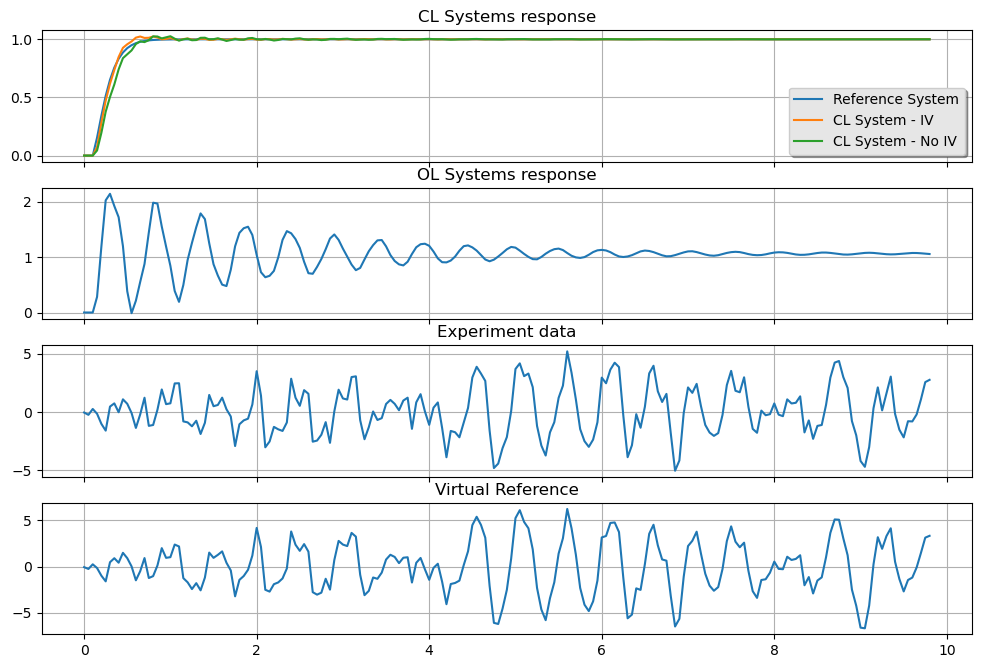

In [9]:
# Closed loop system
closed_loop_iv = (C_iv * sys).feedback()
closed_loop_noiv = (C_noiv * sys).feedback()

t = t[:len(r_iv)]
u = np.ones(len(t))

_, yr = scipysig.dlsim(refModel, u, t)
_, yc_iv = scipysig.dlsim(closed_loop_iv, u, t)
_, yc_noiv = scipysig.dlsim(closed_loop_noiv, u, t)
_, ys = scipysig.dlsim(sys, u, t)

yr = yr.flatten()
ys = ys.flatten()
yc_noiv = yc_noiv.flatten()
yc_iv = yc_iv.flatten()

fig, ax = plt.subplots(4, sharex=True, figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
ax[0].plot(t, yr,label='Reference System')
ax[0].plot(t, yc_iv, label='CL System - IV')
ax[0].plot(t, yc_noiv, label='CL System - No IV')
ax[0].set_title('CL Systems response')
ax[0].grid(True)
ax[1].plot(t, ys, label='OL System')
ax[1].set_title('OL Systems response')
ax[1].grid(True)
ax[2].plot(t, data1.y[:len(r_iv)])
ax[2].grid(True)
ax[2].set_title('Experiment data')
ax[3].plot(t, r_iv)
ax[3].grid(True)
ax[3].set_title('Virtual Reference')

# Now add the legend with some customizations.
legend = ax[0].legend(loc='lower right', shadow=True)

# The frame is matplotlib.patches.Rectangle instance surrounding the legend.
frame = legend.get_frame()
frame.set_facecolor('0.90')


plt.show()
